# <font color=black> Analysis - FC-based parcellation using correlation </font>
<hr style="border:1px solid black">

In [14]:
import sys,json
import glob, os
import numpy as np
import nibabel as nib
import time

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

[autoreload of matplotlib.axes failed: Traceback (most recent call last):
  File "/home/kinany/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/kinany/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/kinany/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/kinany/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/home/kinany/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _SubplotBaseMeta object
]
[autoreload of matplotlib.pyplot failed: Traceback (most recent call last):
  File 

AttributeError: module 'matplotlib' has no attribute 'backend_bases'

# Initialization
<hr style="border:0.5px solid black">

### Load existing configuration file ...

In [2]:
# Load the config file with all information
filetag = "C1toC7_gm_V_precentral"
with open('../../../brain_spine/results/fc_parcellation/corr/' + filetag + '/config_' + filetag + '.json') as config_file:
    config = json.load(config_file)
source = 'spinalcord'
target = 'brain'

### ... or build new one

In [8]:
# Load the config file with all information
with open('../../config/config_fc_based_parcellation_NK.json') as config_file:
    config = json.load(config_file)
# Define tag of this analysis (used for saving)
config['output_tag'] = "C1toC7_gm_wholebrain"
# Define source, target, and the corresponding masks
source = 'spinalcord'
target = 'brain'
# Note: paths should be with respect to main directory
config['file_tag']['brain'] = "_task-rest_bold_stc_brain_moco_brsc_BP_reg_SPM_inTemplate3mm_s.nii.gz"
config['file_tag']['spinalcord'] = "_task-rest_bold_stc_sc_moco_brsc_BP_inTemplate_s.nii.gz"

config['masks']['brain'] = "/analysis/masks/brain_old_3mm/MNI_GM_3mm.nii.gz"
config['masks']['spinalcord'] = "/analysis/masks/spinalcord/PAM50_cord_C1C7_gm.nii.gz"
config['list_subjects'] = ["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]

### Instantiate class
_Note: this will save a config file with all relevant information and prepare folder structure_

In [3]:
fc_parcellation = FC_Parcellation(config,source,target,'corr')

# Analyses
<hr style="border:0.5px solid black">

### Compute the voxelwise correlation & run clustering for each subject independently

In [4]:
start = time.time()
# Loop through the subjects to compute fc and clustering 
for sub_id,sub in enumerate(fc_parcellation.config['list_subjects']): 
    print(f'\033[1mSUBJECT {sub}\033[0m')
    # Compute correlation without saving files
    fc_parcellation.compute_voxelwise_fc(sub=sub, 
                                        overwrite=False)
    # Run clustering and save labels
    fc_parcellation.run_clustering(sub=sub,
                                    k_range=7,algorithm='agglom',
                                    overwrite=False)
print("\033[1m... Operation performed in %.2f s!\033[0m" % (time.time() - start))

SUBJECT P030
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT P099
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A006
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A007
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A008
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A009
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A011
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A013
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A023
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A024
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A025
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A026
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A027
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A028
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A029
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A030
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A032
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A033
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A034
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A036
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A037
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A038
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A039
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A043
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A044
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A045
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A046
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A048
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A050
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A051
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




SUBJECT A052
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... FC already computed

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = agglom
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running agglomerative clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(




... Operation performed in 2208.36 s!


### Compute the group-level clustering and generate corresponding maps

In [5]:
fc_parcellation.group_clustering(k_range=7,indiv_algorithm='agglom',overwrite=False)

CLUSTERING AT THE GROUP LEVEL
K value(s) = 7
Overwrite results = False

K = 7
... Computing hierarchical clustering and relabeling
...... Loading all subjects
...... Clustering on all labels
...... Computing cophenetic correlation
...... Relabeling
...... Computing validity

DONE


In [16]:
fc_parcellation.prepare_target_maps(label_type='indiv',indiv_algorithm='kmeans',k_range=7,overwrite=False)

PREPARE TARGET MAPS
Type of source labels = indiv
K value(s) = 7
Overwrite results = True
K = 7
... Computing target maps
...... Subject P030
...... Subject P099
...... Subject A006
...... Subject A007
...... Subject A008
...... Subject A009
...... Subject A011
...... Subject A013
...... Subject A023
...... Subject A024
...... Subject A025
...... Subject A026
...... Subject A027
...... Subject A028
...... Subject A029
...... Subject A030
...... Subject A032
...... Subject A033
...... Subject A034
...... Subject A036
...... Subject A037
...... Subject A038
...... Subject A039
...... Subject A043
...... Subject A044
...... Subject A045
...... Subject A046
...... Subject A048
...... Subject A050
...... Subject A051
...... Subject A052
DONE



### Plot validity metrics

VALIDITY METRICS
K value(s) = [2, 4]
Saving figures = False



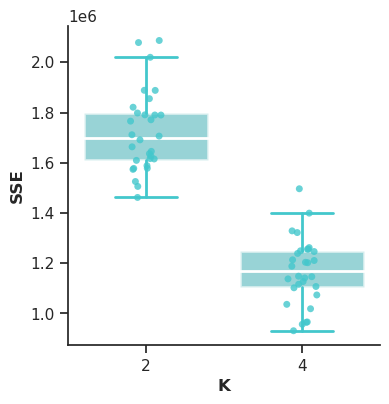

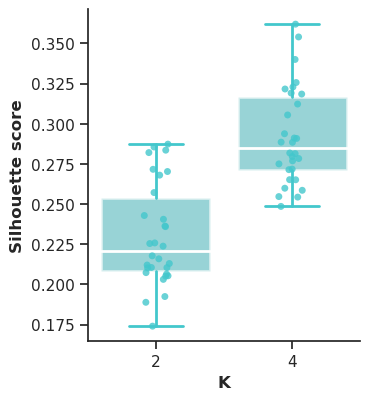

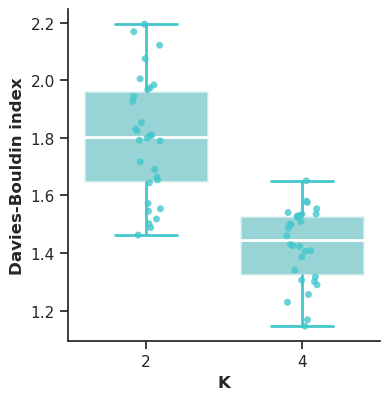

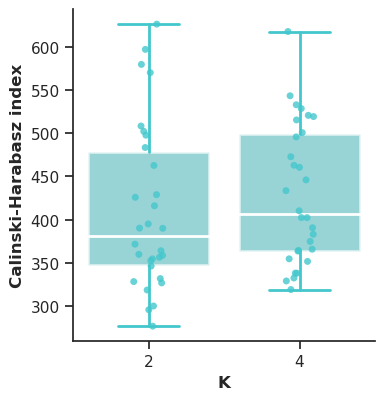

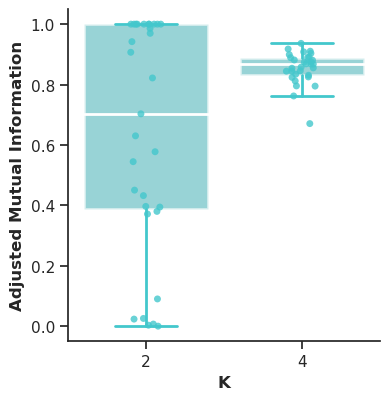

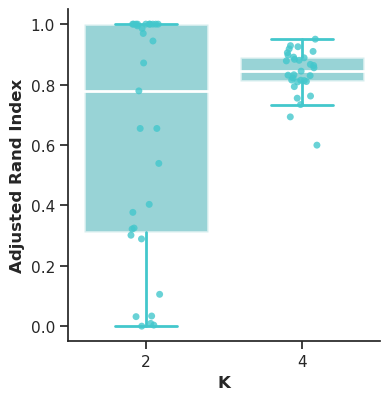

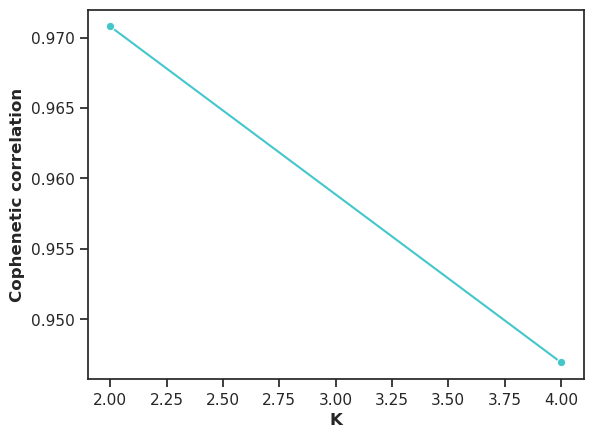

In [28]:
fc_parcellation.plot_validity(k_range=[2,4],internal=["SSE", "silhouette", "davies", "calinski"], group=["ami", "ari", "corr"], save_figures=False)

VALIDITY METRICS
K value(s) = range(2, 15)
Saving figures = False



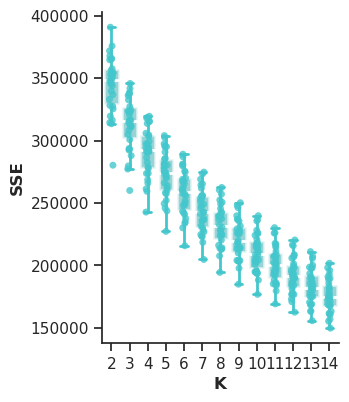

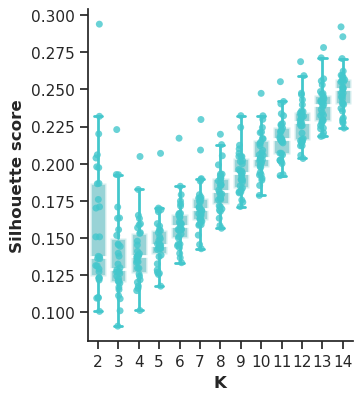

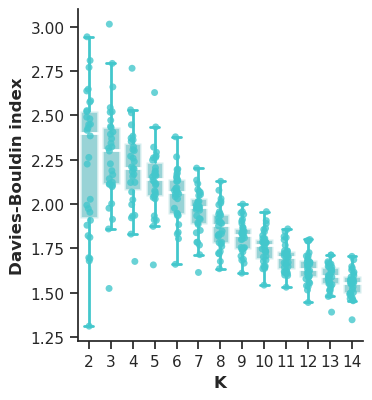

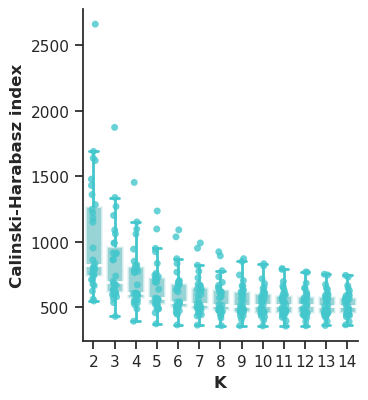

In [20]:
fc_parcellation.plot_validity(k_range=range(2,15),internal=["SSE", "silhouette", "davies", "calinski"], save_figures=False)